05-observation-based-mechanism.ipynb
======================

**Things to do**
* Test code.
* Find the number of unique cheaters who harmed other players severely.

**Sample match ID for testing**
* 000213be-6b3b-438a-8d20-c1b57b01a174 (no cheater)
* 07a471f7-4776-460d-b896-1306b98b6d19 (one cheater)
* 15e457b1-0940-47ca-a730-de0dfd1ccd77 (two cheaters)

## Load packages and read tables.

In [1]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.types import StructType, StructField, LongType
import pubg_analysis as pubg

In [2]:
# Read a table that contains edges.
td = spark.read.parquet("s3://jinny-capstone-data-test/data_for_obs_mech.parquet")
td.registerTempTable("td")

# Read a table that contains cheater data.
cheaters = spark.read.parquet("s3://jinny-capstone-data-test/cheater_info.parquet")
cheaters.registerTempTable("cheaters")

# Read a table that contains nodes.
nodes = spark.read.parquet("s3://jinny-capstone-data-test/nodes.parquet")
nodes.registerTempTable("nodes")

In [3]:
# Show the first few rows of each dataset.
td.show(5)
cheaters.show(5)
nodes.show(5)

+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|                 mid|                 src|src_bd|src_flag|                 dst|dst_bd|dst_flag|                time|    m_date|
+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|000ec388-a3d7-422...|account.c84796ba7...|    NA|       0|account.5028c61d0...|    NA|       0|2019-03-03 16:14:...|2019-03-03|
|000ec388-a3d7-422...|account.cba82f51c...|    NA|       0|account.b347ea78f...|    NA|       0|2019-03-03 16:33:...|2019-03-03|
|000ec388-a3d7-422...|account.8f011f0fd...|    NA|       0|account.e2f45b350...|    NA|       0|2019-03-03 16:16:...|2019-03-03|
|000ec388-a3d7-422...|account.73324618c...|    NA|       0|account.7911e1c3d...|    NA|       0|2019-03-03 16:12:...|2019-03-03|
|000ec388-a3d7-422...|account.ba7ff30f8...|    NA|       0|account.4e93215ae...|    NA|       0|2

## 1. Count the number of motifs on the empirical network.

In [3]:
# First, assume that victims are severely harmed if they were killed after getting into the top 30 percent.
res_tab = pubg.add_level_of_harm(td, 30)
res_tab.registerTempTable("new_td")
res_tab.show(5)

+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+------+
|                 mid|                 src|src_bd|src_flag|                 dst|dst_bd|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+------+
|0000d4aa-07fb-4b3...|account.1866a3c61...|    NA|       0|account.cd31e8ad9...|    NA|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.528ab8eb6...|    NA|       0|account.e5e3583f7...|    NA|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.bdea579b5...|    NA|       0|account.695c4609e...|    NA|       0|2019-03-03 15:57:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.695c4609e...|    NA|       0|account.16c355b96...|    NA|       0|2019-03-03 15:56:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.695c4609e...|    N

In [6]:
records = pubg.add_more_info(res_tab, nodes)
records.registerTempTable("records")

In [7]:
# Get a summary table of the empirical network.
obs_sum_tab = pubg.get_obs_summary_tab(records)
obs_sum_tab.show()

+--------------------+----------+----------+------+---------+-------------+-------------+
|                  id|start_date|    m_date|period|total_obs|total_sev_dam|uniq_cheaters|
+--------------------+----------+----------+------+---------+-------------+-------------+
|account.8d69e3520...|2019-03-02|2019-03-01|     1|       59|           21|            7|
|account.11dbd81ee...|2019-03-02|2019-03-01|     1|        9|            1|            4|
|account.da1a6fa0b...|2019-03-02|2019-03-01|     1|       35|           17|            1|
|account.27478c512...|2019-03-02|2019-03-01|     1|       50|           16|            6|
|account.e493e8036...|2019-03-02|2019-03-01|     1|       23|            0|            3|
|account.642deac91...|2019-03-02|2019-03-01|     1|        2|            0|            1|
|account.d30a1abaf...|2019-03-02|2019-03-01|     1|       18|            0|            3|
|account.71aea180f...|2019-03-02|2019-03-01|     1|        6|            3|            1|
|account.5

In [14]:
# Store the summary table in the S3 bucket for the later use.
obs_sum_tab.write.parquet("s3://jinny-capstone-data-test/summary-tables/emp-net/obs_tab.parquet")

In [ ]:
# Store the summary table as an excel file.
# obs_info_df = obs_sum_tab.toPandas()
# obs_info_df.to_csv('obs_info_df.csv')

The plot below shows the distribution of the number of times the player observed cheating before the transition happened.<br>
In this case, we allow duplicate pairs of cheater and observer as there are some players who have observed the same cheaters more than once.

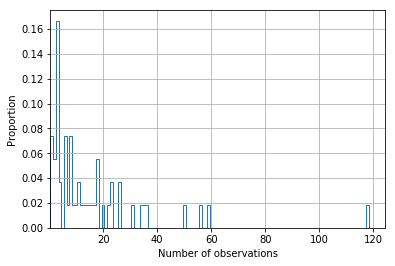

In [15]:
# Plot the distribution of the total number of observations. 
obs_info_df = obs_sum_tab.toPandas()

bins = np.arange(0, obs_info_df['total_obs'].max() + 1.5) - 0.5
fig = obs_info_df.hist(column = 'total_obs', histtype='step', bins = bins, 
                       weights=np.zeros_like(obs_info_df['total_obs'])+1./len(obs_info_df['total_obs']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of observations")
plt.ylabel("Proportion")
plt.title("")
plt.show() 

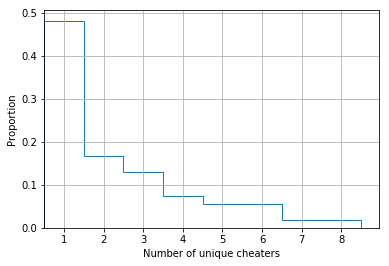

In [16]:
# Plot the distribution of the number of unique cheaters.
# In this case, we consider only unique pairs of cheater and observer.
bins = np.arange(0, obs_info_df['uniq_cheaters'].max() + 1.5) - 0.5
fig = obs_info_df.hist(column = 'uniq_cheaters', histtype='step', bins = bins, 
                       weights=np.zeros_like(obs_info_df['uniq_cheaters'])+1./len(obs_info_df['uniq_cheaters']))
plt.xlim(xmin=0.5)
plt.xlabel("Number of unique cheaters")
plt.ylabel("Proportion")
plt.title("")
plt.show()

## 2. Reuse the mapping table in the S3 bucket to create randomised networks.

In [8]:
# Read a table that contains team membership data.
team_info = spark.read.parquet("s3://jinny-capstone-data-test/team_data.parquet")
team_info.registerTempTable("team_ids")
team_info.show(5)

+--------------------+--------------------+---+
|                 mid|                  id|tid|
+--------------------+--------------------+---+
|a2983171-7f4b-41a...|account.e71c81b51...|  8|
|87fa7a64-8296-46d...|account.4fc0cf786...| 25|
|9d8128bb-62b9-4db...|account.05c8f38ba...| 18|
|7a8874eb-ef3b-451...|account.d53c68f6a...| 10|
|eaf29706-a41b-4a1...|account.562041b51...|  2|
+--------------------+--------------------+---+
only showing top 5 rows



In [17]:
# Read the mapping table.
map_tab = spark.read.parquet("s3://jinny-capstone-data-test/mapping-tables/map_tab_3.parquet")
map_tab.registerTempTable("map_tab")
map_tab.show(5)

+--------------------+--------------------+---------+--------+--------------------+---------+--------+
|            match_id|            original|orig_flag|orig_tid|          randomised|rand_flag|rand_tid|
+--------------------+--------------------+---------+--------+--------------------+---------+--------+
|917c83ff-c92d-4d1...|account.428f21430...|        0|      NA|account.8c710dc6c...|        0|      NA|
|917c83ff-c92d-4d1...|account.bf9e1ebc5...|        0|      NA|account.98299050d...|        0|      NA|
|917c83ff-c92d-4d1...|account.de82d0ce6...|        0|      NA|account.100ec39b7...|        0|      NA|
|917c83ff-c92d-4d1...|account.34da660de...|        0|      NA|account.e14afabf7...|        0|      NA|
|917c83ff-c92d-4d1...|account.5bf305183...|        0|      NA|account.655e0fe02...|        0|      NA|
+--------------------+--------------------+---------+--------+--------------------+---------+--------+
only showing top 5 rows



In [18]:
# Get randomised gameplay logs.
temp_rand_logs = spark.sql("""SELECT mid, src, randomised AS new_src, dst, time, m_date 
                              FROM td t JOIN map_tab m ON t.src = m.original AND t.mid = m.match_id""")
temp_rand_logs.registerTempTable("temp_rand_logs")
randomised_logs = spark.sql("""SELECT mid, new_src AS src, randomised AS dst, time, m_date 
                               FROM temp_rand_logs t JOIN map_tab m 
                               ON t.dst = m.original AND t.mid = m.match_id""")

randomised_logs.show(5)
randomised_logs.registerTempTable("randomised_logs")

+--------------------+--------------------+--------------------+--------------------+----------+
|                 mid|                 src|                 dst|                time|    m_date|
+--------------------+--------------------+--------------------+--------------------+----------+
|8944786b-0021-4a4...|account.88a843735...|account.0001531a9...|2019-03-03 17:50:...|2019-03-03|
|4a5152fa-e942-47d...|account.ac81f0677...|account.beb3d266f...|2019-03-01 17:08:...|2019-03-01|
|dd6286b5-8c40-437...|account.d4a4282a8...|account.d1df632b0...|2019-03-01 15:48:...|2019-03-01|
|54a9f240-74d9-404...|account.bc0bbdca5...|account.a6c4968e4...|2019-03-01 10:07:...|2019-03-01|
|53ca0690-f2d8-480...|account.2e131b2ef...|account.0014fce00...|2019-03-03 05:04:...|2019-03-03|
+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



## 3. Count the number of motifs on the randomised network.

In [19]:
# Add the cheating flags of players.
add_flags = spark.sql("""SELECT mid, src, ban_date AS src_bd, cheating_flag AS src_flag, 
                         dst, time, m_date 
                         FROM randomised_logs r JOIN nodes n ON r.src = n.id""")
add_flags.registerTempTable("add_flags")

randomised_logs = spark.sql("""SELECT mid, src, src_bd, src_flag, 
                               dst, ban_date AS dst_bd, cheating_flag AS dst_flag, time, m_date 
                               FROM add_flags r JOIN nodes n ON r.dst = n.id""")
randomised_logs.registerTempTable("td")
randomised_logs.show(5)

+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|                 mid|                 src|src_bd|src_flag|                 dst|dst_bd|dst_flag|                time|    m_date|
+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+
|297788d0-ef37-4ab...|account.50a01d43a...|    NA|       0|account.001017dce...|    NA|       0|2019-03-02 07:29:...|2019-03-02|
|fcaf8c76-4e7a-4b9...|account.75f15a397...|    NA|       0|account.001017dce...|    NA|       0|2019-03-02 06:56:...|2019-03-02|
|d7b4a476-007b-4e7...|account.ff01e3c0d...|    NA|       0|account.0017aeb1b...|    NA|       0|2019-03-01 08:35:...|2019-03-01|
|4f356644-a887-49f...|account.9c232d9f5...|    NA|       0|account.00399d4c2...|    NA|       0|2019-03-01 04:13:...|2019-03-01|
|d8324042-12e1-401...|account.e2d270189...|    NA|       0|account.00399d4c2...|    NA|       0|2

In [20]:
rand_logs = pubg.add_level_of_harm(randomised_logs, 30)
rand_logs.registerTempTable("new_td")
rand_logs.show(5)

+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+------+
|                 mid|                 src|src_bd|src_flag|                 dst|dst_bd|dst_flag|                time|    m_date|damage|
+--------------------+--------------------+------+--------+--------------------+------+--------+--------------------+----------+------+
|0000d4aa-07fb-4b3...|account.bdea579b5...|    NA|       0|account.e5e3583f7...|    NA|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.05dd3a28f...|    NA|       0|account.cd31e8ad9...|    NA|       0|2019-03-03 15:58:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.528ab8eb6...|    NA|       0|account.71db99b02...|    NA|       0|2019-03-03 15:57:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.71db99b02...|    NA|       0|account.dd74cf084...|    NA|       0|2019-03-03 15:56:...|2019-03-03|     1|
|0000d4aa-07fb-4b3...|account.71db99b02...|    N

In [21]:
records = pubg.add_more_info(rand_logs, nodes)
records.registerTempTable("records")

In [22]:
# Get a summary table of the randomised network.
obs_sum_tab = pubg.get_obs_summary_tab(records)
obs_sum_tab.show()

+--------------------+----------+----------+------+---------+-------------+-------------+
|                  id|start_date|    m_date|period|total_obs|total_sev_dam|uniq_cheaters|
+--------------------+----------+----------+------+---------+-------------+-------------+
|account.8d69e3520...|2019-03-02|2019-03-01|     1|       41|           20|            7|
|account.11dbd81ee...|2019-03-02|2019-03-01|     1|        9|            1|            4|
|account.da1a6fa0b...|2019-03-02|2019-03-01|     1|       17|            3|            1|
|account.27478c512...|2019-03-02|2019-03-01|     1|       31|           10|            5|
|account.e493e8036...|2019-03-02|2019-03-01|     1|       23|            0|            3|
|account.642deac91...|2019-03-02|2019-03-01|     1|        2|            0|            1|
|account.d30a1abaf...|2019-03-02|2019-03-01|     1|       32|           19|            3|
|account.71aea180f...|2019-03-02|2019-03-01|     1|        3|            3|            1|
|account.a

In [23]:
# Store the summary table in the S3 bucket for the later use.
obs_sum_tab.write.parquet("s3://jinny-capstone-data-test/summary-tables/rand-net/obs_tab_3.parquet")

In [31]:
# Download an excel file that contains the summary table of the randomised network.
# obs_info_df = obs_sum_tab.toPandas()
# obs_info_df.to_csv('rand_obs_info_df.csv')